# Museums in the Pandemic - Text analytics

**Author**: Andrea Ballatore (Birkbeck, University of London)

**Abstract**: TODO

## Setup
This is to check that your environment is set up correctly (it should print 'env ok', ignore warnings).

In [18]:
# Test geospatial libraries
# check environment
import os
print("Conda env:", os.environ['CONDA_DEFAULT_ENV'])
if os.environ['CONDA_DEFAULT_ENV'] != 'mip_v1':
    raise Exception("Set the environment 'mip_v1' on Anaconda. Current environment: " + os.environ['CONDA_DEFAULT_ENV'])

# spatial libraries 
import pandas as pd
import pickle
from termcolor import colored
import sys
import spacy
import numpy as np
#import tensorflow as tf
from bs4 import BeautifulSoup
from bs4.element import Comment
#import torch
import matplotlib.pyplot as plt

# import from `mip` project
print(os.getcwd())
fpath = os.path.abspath('../')
if not fpath in sys.path:
    sys.path.insert(0, fpath)

out_folder = '../../'

from museums import *
from utils import _is_number

print('env ok')

Conda env: mip_v1
/Users/andreab/Dropbox/DRBX_Docs/Work/Projects/github_projects/museums-in-the-pandemic/mip/notebooks
env ok


# Museum text analytics


## Model1: Vectorise text from museum websites

### Connect to DB

In [19]:
# open connection to DB
from db.db import connect_to_postgresql_db

db_conn = connect_to_postgresql_db()
print("DB connected")

DB connected


### Setup spacy NLP

In [7]:
# install language model
!python -m spacy download en_core_web_sm
# Note: if this cell does not work, run the same command 
#       without "!" in the Anaconda terminal

     |████████████████████████████████| 12.0 MB 5.2 MB/s eta 0:00:01
  Created wheel for en-core-web-sm: filename=en_core_web_sm-2.3.1-py3-none-any.whl size=12047106 sha256=6e736cfbfe09463c336696b4717b7863a88b5d6766fe3bbf830fc9b77c861a42
  Stored in directory: /private/var/folders/84/_52b_kt95ybgx9pwl31_nvqh0000gn/T/pip-ephem-wheel-cache-dcoj7ilh/wheels/ee/4d/f7/563214122be1540b5f9197b52cb3ddb9c4a8070808b22d5a84
Successfully built en-core-web-sm
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')


In [5]:
# set up the spacy environment
import spacy
from spacy import displacy
from collections import Counter
spacy.prefer_gpu()
# load language model
import en_core_web_sm
nlp = en_core_web_sm.load()

In [7]:
# Spacy stopwords
#all_stopwords = nlp.Defaults.stop_words

In [8]:
# get text from websites

from analytics.an_websites import get_attribute_for_webpage_url

session_id = '20210420'
test_urls = ['https://www.britishmuseum.org/']
attrib_name = 'all_text' # 'title'

for url in test_urls:
    print(url)
    res = get_attribute_for_webpage_url(url, session_id, attrib_name, db_conn)
    if not res: continue
    print(res)
    blocks = res.split("\n")
    print("LEN", len(blocks))
    print(blocks)

https://www.britishmuseum.org/
Skip to main content Please enable JavaScript in your web browser to get the best experience. We use cookies to make our website work more efficiently, to provide you with more personalised services or advertising to you, and to analyse traffic on our website. For more information on how we use cookies and how to manage cookies, please follow the 'Read more' link, otherwise select 'Accept and close'. Read more about our cookie policy Accept and close the cookie policy Menu Main navigation Visit Toggle Visit submenu Back
to previous menu —
Visit —
Visit —
Family visits —
Group visits —
Audio guide —
Out-of-hours tours —
Tours and talks —
Object trails —
Accessibility —
Food and drink —
Late opening on Fridays —
Museum map Exhibitions and events Collection Toggle Collection submenu Back
to previous menu —
Collection —
Collection —
Collection online —
Galleries —
Blog —
Audio tour highlights —
The British Museum podcast Learn Toggle Learn submenu Back
to pre

### Preprocess text

In [9]:
MOVED

def spacy_extract_tokens(text):
    """ 
    @returns data frame with tokens with POS, lemma, stop words
    """
    tokens_df = pd.DataFrame()
    text_sentences = nlp(text)
    sent_id = 0
    # segment sentences
    for sentence in text_sentences.sents:
        sent_id += 1
        # for each sentence
        snt_text = sentence.text
        pos_df = pd.DataFrame()
        print(colored('>', 'red'), snt_text)
        for token in sentence:
            # for each token
            tokens_df = tokens_df.append(pd.DataFrame(
                {"sentence_id": sent_id, "token":token.text, 'lemma':token.lemma_,
                 "pos_tag":token.pos_, 'is_stop': token.is_stop}, 
                index=[0]), ignore_index=True)
    return tokens_df

test_texts = ["""We need your support Your support is vital and helps the Museum to share the collection with the world. Make a donation What's online... The flowers of Mary Delany 233 years after her death, Delany's detailed floral collages still delight and inspire. Take a closer look at her work in the collection. How to explore the British Museum from home Whether it's a behind-the-scenes podcast or a closer look at our galleries, here are 10 ways to explore the Museum while we're closed. British histories beyond 'Bridgerton' Inspired by the hit Netflix show, watch a panel discussion exploring the reality behind the fantasy of 'Bridgerton'. Discover the Maya World Take a trip to Mexico and explore a wealth of content from the Maya Research Project, including stories, videos and 3D explorations."""]

for tt in test_texts:
    print(tt)
    print("")
    df = spacy_extract_tokens(tt)
    print("Tokens N =",len(df))
    fout = out_folder+'tmp/museum_text_tokens.csv'
    df.to_csv(fout, index=False)
    print("See tokens in",fout)


We need your support Your support is vital and helps the Museum to share the collection with the world. Make a donation What's online... The flowers of Mary Delany 233 years after her death, Delany's detailed floral collages still delight and inspire. Take a closer look at her work in the collection. How to explore the British Museum from home Whether it's a behind-the-scenes podcast or a closer look at our galleries, here are 10 ways to explore the Museum while we're closed. British histories beyond 'Bridgerton' Inspired by the hit Netflix show, watch a panel discussion exploring the reality behind the fantasy of 'Bridgerton'. Discover the Maya World Take a trip to Mexico and explore a wealth of content from the Maya Research Project, including stories, videos and 3D explorations.

> We need your support Your support is vital and helps the Museum to share the collection with the world.
> Make a donation
> What's online...
> The flowers of Mary Delany 233 years after her death, Delany'

### Annotations

In [3]:
# extract tokens from annotations
from analytics.text_models import get_indicator_annotations

indic_df, ann_df = get_indicator_annotations("../../")
ann_df

,text_phrases,indicator_code,indicator_attributes,notes,example_id
0,Closed now,closed_cur,NaN,NaN,0
1,closed to members of the public until further ...,closed_cur,NaN,NaN,1
2,closed until further notice,closed_cur,NaN,NaN,2
3,closed until Spring 2021,closed_cur,NaN,NaN,3
4,Closed: Until further notice,closed_cur,NaN,NaN,4
...,...,...,...,...,...
146,Bailiffgate is now closed due to Covid.,closed_cur,NaN,NaN,146
147,Visit our online shop,open_onlineshop,NaN,NaN,147
148,The new stunning Felton Group online exhibitio...,online_exhib,_description,NaN,148
149,Stay up to date with what's happening at Baili...,online_engag,NaN,NaN,149


In [4]:
ann_tokens_df = pd.DataFrame()

for index, row in ann_df.iterrows():
    txt = str(row['text_phrases']).strip()
    df = spacy_extract_tokens(txt)
    #print(df)
    df['example_id'] = row['example_id']
    df['indicator_code'] = row['indicator_code']
    ann_tokens_df = pd.concat([ann_tokens_df, df])

# output annotations tokens
fout = out_folder+'tmp/test_annotations_tokens.csv'
ann_tokens_df.to_csv(fout, index=False)
print(fout)

NameError: name 'spacy_extract_tokens' is not defined

### Indicator matching

This code identifies indicators in raw text

In [6]:
ftext = out_folder+'tmp/museum_text_tokens.csv'
text_df = pd.read_csv(ftext)
print(len(text_df))
text_df.sample(10)

findic = out_folder+'tmp/test_annotations_tokens.csv'
ann_df = pd.read_csv(findic)
print(len(ann_df))

ann_df

155
1857


,sentence_id,token,lemma,pos_tag,is_stop,example_id,indicator_code
0,1,Closed,close,VERB,False,0,closed_cur
1,1,now,now,ADV,True,0,closed_cur
2,1,closed,close,VERB,False,1,closed_cur
3,1,to,to,ADP,True,1,closed_cur
4,1,members,member,NOUN,False,1,closed_cur
...,...,...,...,...,...,...,...
1852,1,'ve,have,AUX,True,150,made_covid_safe
1853,1,made,make,VERB,True,150,made_covid_safe
1854,1,your,-PRON-,DET,True,150,made_covid_safe
1855,1,visit,visit,NOUN,False,150,made_covid_safe


Options for matches
- Case sensitive/insens (lower case) 
- match lemma
- match token
- stopwords or not

In [9]:
print(text_df.columns)
print(ann_df.columns)

Index(['sentence_id', 'token', 'lemma', 'pos_tag', 'is_stop'], dtype='object')
Index(['sentence_id', 'token', 'lemma', 'pos_tag', 'is_stop', 'example_id',
       'indicator_code'],
      dtype='object')


In [41]:
MOVED

def _filter_tokens(df, keep_stopwords=True):
    """ Remove tokens that do not carry semantic content """
    
    if not keep_stopwords:
        df = df[~df['is_stop']]
    
    filt_df = df[~df['pos_tag'].isin(['DET','ADP','PRON','PUNCT'])]
    return filt_df


def _match_tokens(musetxt_df, annot_df, case_sensitive, keep_stopwords):
    """
    TODO
    """
    assert len(musetxt_df)>=0
    assert len(annot_df)>=0
    # set up options
    prefix = 'var_'
    suffix = ''
    if case_sensitive: suffix = '_csens'
    else: suffix = '_cinsens'
    if case_sensitive: suffix = '_csens'
    else: suffix = '_cinsens'
        
    if keep_stopwords: suffix += '_wstopw'
    else: suffix += '_nostopw'
        
    # filter tokens
    filt_text_df = _filter_tokens(musetxt_df, keep_stopwords)
    filt_ann_df = _filter_tokens(annot_df, keep_stopwords)
    
    # case in/sensitive
    if not case_sensitive:
        # make lower case
        filt_text_df.loc[:, 'lemma'] = filt_text_df.loc[:, 'lemma'].str.lower()
        filt_text_df.loc[:, 'token'] = filt_text_df.loc[:, 'token'].str.lower()
        filt_ann_df.loc[:, 'lemma'] = filt_ann_df.loc[:, 'lemma'].str.lower()
        filt_ann_df.loc[:, 'token'] = filt_ann_df.loc[:, 'token'].str.lower()
        
    # generate match variables for each example/text pair
    lemmas_df = filt_text_df.merge(filt_ann_df, on=['lemma'])
    tokens_df = filt_text_df.merge(filt_ann_df, on=['token'])
    lemmas_m = " ".join(lemmas_df['lemma'].tolist())
    tokens_m = " ".join(tokens_df['token'].tolist())
    vars_d = {
        prefix+'lemmas_n'+suffix:len(lemmas_df), 
        prefix+'lemmas_m'+suffix: lemmas_m, 
        prefix+'tokens_n'+suffix:len(tokens_df),
        prefix+'tokens_m'+suffix: tokens_m
    }
    return vars_d


def match_musetext_indicators(muse_id, txt_df, annot_df):
    """ Main match loop between set of sentences and set of annotations """
    assert muse_id
    assert len(txt_df) >= 0
    assert len(annot_df) >= 0
    
    df = pd.DataFrame()
    
    for sentence_name, txt_sent_df in txt_df.groupby('sentence_id'):
        #print(txt_sent_df)
        for ann_name, ann_example_df in annot_df.groupby('example_id'):
            #print(ann_example_df)
            tmpdf = _match_musetext_vs_indicator_example(muse_id, txt_sent_df, ann_example_df)
            df = df.append(tmpdf)
    
    df.reset_index()
    return df

    
def _match_musetext_vs_indicator_example(muse_id, txt_df, annot_df):
    """ 
    Match single text sentence with single annotation example
    """
    #print("_match_musetext_vs_indicator_example")
    # get txt sentence id
    sentence_id = txt_df['sentence_id'].tolist()[0]
    # get annotation example id and code
    example_id = annot_df['example_id'].tolist()[0]
    indicator_code = annot_df['indicator_code'].tolist()[0]
    
    d = {}
    for cs in [True, False]:
        for sw in [True, False]:
            #print('debug 2')
            match_vars_d = _match_tokens(txt_df, annot_df, cs, sw)
            d.update(match_vars_d)
    
    # sum all values
    all_nums = [x for x in d.values() if _is_number(x)]
    d['all_sum_n'] = sum(all_nums)
    
    # base dictionary
    res_d = {'muse_id':muse_id, 
             'muse_text_sentence_id': [sentence_id], 
             'annotation_example_id':[example_id],
             'muse_text_sentence_len': len(txt_df), 
             'annotation_example_len': len(annot_df)}
    res_d.update(d)
    
    res_df = pd.DataFrame(data=res_d)
    assert len(res_df)>0
    return res_df

In [42]:
# call test match 
muse_id = 'test.123'
df = match_musetext_indicators(muse_id, text_df, ann_df)

print(len(df))
fout = out_folder + 'tmp/all_matches_test.csv'
df.to_csv(fout, index=False)

1510


In [71]:
OLD
# iterate over each group
#for group_name, df_group in df1_grouped:
    
    # match lemmas
    matched_df = filt_text_df.merge(filt_ann_df, on=target_col, suffixes=('_txt', '_ann'))
    print(matched_df.columns)
    matched_df.to_csv(out_folder+'tmp/indic_match_counts_all.csv', index=False)

    df = matched_df.groupby(['sentence_id_txt','example_id','indicator_code']).size().reset_index(name='n_match_'+target_col)
    print(df)
    df.to_csv(out_folder+'tmp/indic_match_counts_counts.csv', index=False)
    #return df
    
mdf = match_tokens(text_df, ann_df, 'lemma')
tdf = match_tokens(text_df, ann_df, 'token')
all_matches_df = mdf.merge(tdf, on=['sentence_id_txt','example_id','indicator_code'], how='outer')

all_matches_df['n_match_lemma'] = all_matches_df['n_match_lemma'].fillna(0)
all_matches_df['n_match_token'] = all_matches_df['n_match_token'].fillna(0)
all_matches_df

Index(['sentence_id', 'token', 'lemma', 'pos_tag', 'is_stop'], dtype='object')
Index(['sentence_id', 'token', 'lemma', 'pos_tag', 'is_stop', 'example_id',
       'indicator_code'],
      dtype='object')


NameError: name 'df1_grouped' is not defined

## Text analysis from DB

Analyse text stats from DB
### Load data

In [3]:
assert db_conn

t = "analytics.text_indic_ann_matches"
sql = """select count(distinct muse_id) from {} t;""".format(t)
print(sql)
df = pd.read_sql(sql, db_conn)
df

select count(distinct muse_id) from analytics.text_indic_ann_matches t;


,count
0,346


In [5]:
mus_df = get_museums_sample_urls(out_folder)

museums urls: ../../data/museums/correct_url_stratified_sample_401.tsv
get_museums_w_web_urls Museums=400 URLs=400


In [9]:
sample_df = mus_df.sample(10)
muse_ids = sample_df.muse_id.tolist()
muse_ids = str(muse_ids).replace('[','(').replace(']',')')
#print(muse_ids)
sql = """select * from {} t where muse_id in {};""".format(t, muse_ids)
print(sql)
df = pd.read_sql(sql, db_conn)

fn = out_folder + 'tmp/match_samples.tsv'
print(df.keep_stopwords.describe())
df.to_csv(fn, sep='\t', index=False)
df.describe().transpose()

select * from analytics.text_indic_ann_matches t where muse_id in ('mm.aim.1315', 'mm.mald.030', 'mm.domus.SE505', 'mm.wiki.023', 'mm.domus.SW215', 'mm.domus.SE131', 'mm.domus.YH157', 'mm.ace.1101', 'mm.aim.0713', 'mm.wiki.129');
count     25104
unique        2
top        True
freq      20627
Name: keep_stopwords, dtype: object


,count,mean,std,min,25%,50%,75%,max
lemma_n,25104.0,1.139261,0.436145,0.0,1.00000,1.00000,1.00000,6.0
lemma_n_wdupl,25104.0,1.328235,0.706257,0.0,1.00000,1.00000,1.00000,9.0
token_n,25104.0,0.621256,0.622862,0.0,0.00000,1.00000,1.00000,4.0
token_n_wdupl,25104.0,0.727533,0.818129,0.0,0.00000,1.00000,1.00000,6.0
sent_len,25104.0,13.023223,7.202616,1.0,8.00000,12.00000,17.00000,48.0
example_len,25104.0,6.938217,3.630392,1.0,4.00000,6.00000,9.00000,18.0
ann_overlap_lemma,25104.0,0.210361,0.138961,0.0,0.12500,0.16667,0.25000,1.0
ann_overlap_token,25104.0,0.105525,0.133616,0.0,0.00000,0.08333,0.16667,1.0
txt_overlap_lemma,25104.0,0.127344,0.132345,0.0,0.06667,0.09091,0.14286,1.0
txt_overlap_token,25104.0,0.063528,0.096628,0.0,0.00000,0.04545,0.09091,1.0


In [80]:
# get data (SLOW)
sql = """select keep_stopwords, example_id, indicator_code, token_n, lemma_n, ann_overlap_lemma, ann_overlap_token 
    from analytics.text_indic_ann_matches t;"""
df = pd.read_sql(sql, db_conn)
print(len(df))

1256977


### Distributions

In [96]:
# descriptive stats of all values
df.groupby('keep_stopwords').describe().transpose()

keep_stopwords                   False         True 
token_n           count  217168.000000  1.039809e+06
                  mean        0.608708  6.841516e-01
                  std         0.581596  6.388096e-01
                  min         0.000000  0.000000e+00
                  25%         0.000000  0.000000e+00
                  50%         1.000000  1.000000e+00
                  75%         1.000000  1.000000e+00
                  max         5.000000  8.000000e+00
lemma_n           count  217168.000000  1.039809e+06
                  mean        1.021325  1.170264e+00
                  std         0.344305  4.652746e-01
                  min         0.000000  0.000000e+00
                  25%         1.000000  1.000000e+00
                  50%         1.000000  1.000000e+00
                  75%         1.000000  1.000000e+00
                  max         5.000000  8.000000e+00
ann_overlap_lemma count  217168.000000  1.039809e+06
                  mean        0.279992  1.920642e-01
                  std         0.192090  1.150440e-01
                  min         0.000000  0.000000e+00
                  25%         0.166670  1.176500e-01
                  50%         0.250000  1.666700e-01
                  75%         0.333330  2.500000e-01
                  max         1.000000  1.000000e+00
ann_overlap_token count  217168.000000  1.039809e+06
                  mean        0.164352  1.066271e-01
                  std         0.206843  1.215185e-01
                  min         0.000000  0.000000e+00
                  25%         0.000000  0.000000e+00
                  50%         0.111110  1.000000e-01
                  75%         0.250000  1.666700e-01
                  max         1.000000  1.000000e+00

In [97]:
# describe indicators
indic_df = df.groupby(['keep_stopwords','indicator_code']).size().unstack(fill_value=0).transpose()
print(indic_df.columns)
indic_df = indic_df.sort_values(True, ascending=False)
indic_df.to_csv(out_folder+'tmp/indicator_stats.csv')
indic_df

Index([False, True], dtype='object', name='keep_stopwords')


keep_stopwords,False,True
indicator_code,,
funding_fundraise,30604,179632
lang_difficulty,21111,173099
closed_cur,38326,125510
reopen_intent,25939,109884
staff_working,10060,58332
funding_gov_emer,11917,54652
open_onlineshop,11305,47229
online_engag,8091,46243
funding_other_emer,7647,36946


exclude 1 match


keep_stopwords
False    [[AxesSubplot(0.125,0.125;0.775x0.755)]]
True     [[AxesSubplot(0.125,0.125;0.775x0.755)]]
dtype: object

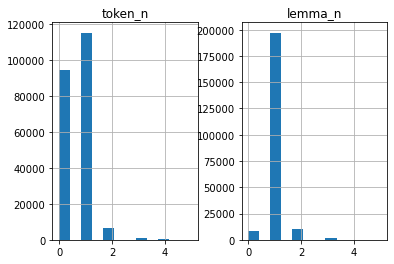

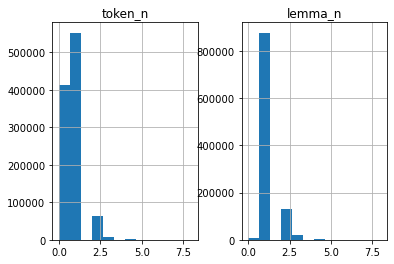

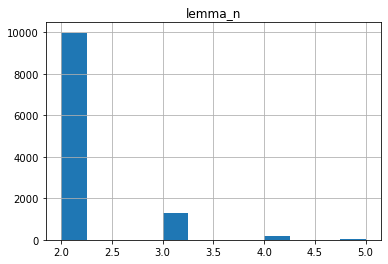

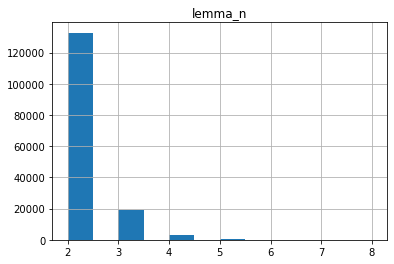

In [98]:
df[['token_n','lemma_n','keep_stopwords']].groupby('keep_stopwords').hist(bins=12)
print('exclude 1 match')
df[['lemma_n','keep_stopwords']][df.lemma_n > 1].groupby('keep_stopwords').hist(bins=12)

# TODO: SHOW HIST OF OVERLAPS

In [109]:
# count number of examples
indic_df = df[['keep_stopwords','indicator_code','example_id']].groupby(['keep_stopwords','indicator_code']).describe()
#.size().unstack(fill_value=0).transpose()
#print(indic_df.columns)
indic_df = indic_df.sort_values(('example_id', 'unique'), ascending=False)
indic_df

example_id                            
                                        count unique           top   freq
keep_stopwords indicator_code                                            
True           funding_fundraise       179632     52  ann_ex_00075  10256
False          funding_fundraise        30604     52  ann_ex_00102   2189
True           reopen_intent           109884     43  ann_ex_00248   9229
False          reopen_intent            25939     43  ann_ex_00226   1870
True           lang_difficulty         173099     39  ann_ex_00137   8771
False          closed_cur               38326     38  ann_ex_00028   3118
               lang_difficulty          21111     38  ann_ex_00162   2180
True           closed_cur              125510     38  ann_ex_00028   7448
False          funding_gov_emer         11917     13  ann_ex_00125   2556
True           funding_gov_emer         54652     13  ann_ex_00121   7472
False          online_engag              8091     12  ann_ex_00176   1553
True           online_engag             46243     12  ann_ex_00178   6873
               staff_working            58332     11  ann_ex_00279   7387
False          staff_working            10060     11  ann_ex_00276   1863
True           open_onlineshop          47229     11  ann_ex_00204  10350
False          open_onlineshop          11305     11  ann_ex_00204   2466
               online_event              5893      9  ann_ex_00188   1424
True           online_event             17195      9  ann_ex_00190   5612
               staff_hiring             28760      8  ann_ex_00269   7580
False          staff_hiring              5908      8  ann_ex_00268   1374
True           online_exhib             14994      7  ann_ex_00196   6522
False          funding_did_not_get       3816      7  ann_ex_00061   1797
True           funding_did_not_get      21680      7  ann_ex_00060   5982
False          online_exhib              4430      7  ann_ex_00196   1218
               closed_indef              7584      6  ann_ex_00042   2438
               finance_health            5447      6  ann_ex_00053   2297
True           finance_health           20147      6  ann_ex_00051   9436
               closed_indef             17180      6  ann_ex_00042   6614
               closed_perm              30823      5  ann_ex_00048   9861
False          closed_perm               2836      5  ann_ex_00048   1050
True           reopen_plan              15344      4  ann_ex_00262   4320
False          funding_other_emer        7647      4  ann_ex_00130   3471
True           funding_other_emer       36946      4  ann_ex_00130  11463
False          reopen_plan               3596      4  ann_ex_00262   1484
               project_postpone          1463      3  ann_ex_00216    712
               open_cur                  5864      3  ann_ex_00202   2629
True           open_cur                  9401      3  ann_ex_00202   5861
               project_postpone         15506      3  ann_ex_00216   5990
               made_covid_safe           3798      1  ann_ex_00170   3798
               open_cafe                 5369      1  ann_ex_00199   5369
               open_garden               2262      1  ann_ex_00203   2262
False          open_cafe                  786      1  ann_ex_00199    786
               staff_restruct             122      1  ann_ex_00272    122
               made_covid_safe           2161      1  ann_ex_00170   2161
True           staff_restruct            5823      1  ann_ex_00272   5823
False          open_garden               2262      1  ann_ex_00203   2262

In [ ]:
#TODO choose sample for manual annotation of matches

In [81]:
OLD
# ann_overlap_lemma, ann_overlap_token
def get_quartiles_db(col_name, table_name, db_conn):
    sql = """select
          percentile_disc(0.0) within group (order by {}) as q0,
          percentile_disc(0.25) within group (order by {}) as q025,
          percentile_disc(0.5) within group (order by {}) as q05,
          percentile_disc(0.75) within group (order by {}) as q075,
          percentile_disc(0.85) within group (order by {}) as q085,
          percentile_disc(0.9) within group (order by {}) as q09,
          percentile_disc(1.0) within group (order by {}) as q1
        from {} t;""".format(col_name,col_name,col_name,col_name,col_name,
                             col_name,col_name,table_name)
    df = pd.read_sql(sql, db_conn)
    df['column'] = col_name
    return df

df = pd.DataFrame()
for col in ['ann_overlap_lemma','ann_overlap_token']:
    df = pd.concat(df, get_quartiles_db(col, 'analytics.text_indic_ann_matches', db_conn))
df

NameError: name 'old' is not defined

End of notebook